In [1]:
import h5py
import numpy as np
import scipy.interpolate as interp
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
h5_path = '../data/easycom/Easycom_N-1020_fs-48k_nrfft-257.h5'
ind_mics = [0,2]
n_mics = len(ind_mics)
f = h5py.File(h5_path,'r')
fs = int(f["fs"][()])
doas = np.array(f['doas']) # (ndarray) [n_az x n_el x 2]
airs = np.array(f['airs'])[:,:,ind_mics,:]       # (ndarray) [n_az x n_el x n_chan x n_smpl]
atfs = np.array(f['atfs'])[...,ind_mics]         # (ndarray) [n_az x n_el x n_rfft x n_chan]
rtfs = np.array(f['rtfs'])[...,ind_mics,ind_mics] # (ndarray) [n_az x n_el x n_rfft x n_chan x n_chan]
mic_pos = np.array(f['mic_pos'])[:,ind_mics]     # (ndarray) [3 x n_chan]
f.close()

atfs = atfs.transpose(0,1,3,2)

assert atfs.shape[:3] == airs.shape[:3]
print(atfs.shape)

(60, 17, 2, 257)


In [87]:
(doas[:,:,0] > 0) & (doas[:,:,0] < 12)

array([[False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [3]:

_doas = doas.reshape(-1,2)
print('OBS', _doas.shape)
n_obs = _doas.shape[0]

_data = atfs
n_smpl = _data.shape[-1]
print(_data.shape)
_data = _data.reshape(n_obs, n_mics, n_smpl)
print('HRTF', _data.shape)

_src_points = []
_data_points = []
for n in range(n_obs):
    if np.abs(np.rad2deg(_doas[n,1])) > 6:
        continue
    if not (np.round(np.rad2deg(_doas[n,0])) % 12) < 1:
        continue

    _src_points.append(_doas[n,:])
    _data_points.append(_data[n,:,:].T)

src_pos_sphere = np.stack(_src_points, axis=0)
data = np.stack(_data_points, axis=0)

src_pos_sphere = np.array(src_pos_sphere)
hrtfData = data

print('After pruning')
print('OBS', src_pos_sphere.shape)
print('HRTF', hrtfData.shape)
print(np.rad2deg(_src_points)[:,0])

OBS (1020, 2)
(60, 17, 2, 257)
HRTF (1020, 2, 257)
After pruning
OBS (30, 2)
HRTF (30, 257, 2)
[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300. 312. 324.
 336. 348.]


In [76]:
print(src_pos_sphere.shape)

def sph2cart(az, el, r):
    return np.stack([
        r * np.cos(el) * np.cos(az),
        r * np.cos(el) * np.sin(az),
        r * np.sin(el)
    ], axis=1)

src_pos_cart = sph2cart(src_pos_sphere[:,0], src_pos_sphere[:,1], 2*np.ones_like(src_pos_sphere[:,0]))
print(src_pos_cart.shape)
print(src_pos_cart[:5,:])

test_az = np.arange(0.,359-12.,6.)
print(test_az)

test_pos_pol = np.stack(np.meshgrid(
    np.deg2rad(test_az),
    np.deg2rad(np.array([0])),
    np.array([2]),
indexing='ij'), axis=-1).reshape(-1,3)

test_pos_cart = sph2cart(test_pos_pol[:,0], test_pos_pol[:,1], test_pos_pol[:,2])
print(test_pos_cart.shape)
print(test_pos_cart[:5,:])

(30, 2)
(30, 3)
[[2.         0.         0.        ]
 [1.9562952  0.41582338 0.        ]
 [1.82709092 0.81347329 0.        ]
 [1.61803399 1.1755705  0.        ]
 [1.33826121 1.48628965 0.        ]]
[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282. 288. 294. 300. 306. 312. 318. 324. 330.
 336. 342.]
(58, 3)
[[2.         0.         0.        ]
 [1.98904379 0.20905693 0.        ]
 [1.9562952  0.41582338 0.        ]
 [1.90211303 0.61803399 0.        ]
 [1.82709092 0.81347329 0.        ]]


In [77]:
# add the frequencies
n_points = data.shape[1]
domain_support = np.linspace(0., 1., n_points)
print(domain_support.shape)

n_angs = src_pos_cart.shape[0]
src_pos_cart_freq = np.repeat(src_pos_cart, n_points, axis=0)
src_freqs = np.tile(domain_support, (n_angs))
src_points = np.concatenate([src_pos_cart_freq, src_freqs[:,None]], axis=-1)
print('TRAIN PTS', src_points.shape)

print(src_points[:20,:])

(257,)
TRAIN PTS (7710, 4)
[[2.         0.         0.         0.        ]
 [2.         0.         0.         0.00390625]
 [2.         0.         0.         0.0078125 ]
 [2.         0.         0.         0.01171875]
 [2.         0.         0.         0.015625  ]
 [2.         0.         0.         0.01953125]
 [2.         0.         0.         0.0234375 ]
 [2.         0.         0.         0.02734375]
 [2.         0.         0.         0.03125   ]
 [2.         0.         0.         0.03515625]
 [2.         0.         0.         0.0390625 ]
 [2.         0.         0.         0.04296875]
 [2.         0.         0.         0.046875  ]
 [2.         0.         0.         0.05078125]
 [2.         0.         0.         0.0546875 ]
 [2.         0.         0.         0.05859375]
 [2.         0.         0.         0.0625    ]
 [2.         0.         0.         0.06640625]
 [2.         0.         0.         0.0703125 ]
 [2.         0.         0.         0.07421875]]


In [78]:
n_angs = test_pos_cart.shape[0]
n_az_test = n_angs
n_rfft_test = n_points
print(n_az_test, n_rfft_test)

domain_support = np.linspace(0., 1., n_points)
test_pos_cart_freq = np.repeat(test_pos_cart, n_points, axis=0)
test_freqs = np.tile(domain_support, (n_angs))
print(test_freqs[:20])
test_points = np.concatenate([test_pos_cart_freq, test_freqs[:,None]], axis=-1)
print('TEST PTS', test_points.shape)


print(test_points[:20,:])

58 257
[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625 0.0390625  0.04296875
 0.046875   0.05078125 0.0546875  0.05859375 0.0625     0.06640625
 0.0703125  0.07421875]
TEST PTS (14906, 4)
[[2.         0.         0.         0.        ]
 [2.         0.         0.         0.00390625]
 [2.         0.         0.         0.0078125 ]
 [2.         0.         0.         0.01171875]
 [2.         0.         0.         0.015625  ]
 [2.         0.         0.         0.01953125]
 [2.         0.         0.         0.0234375 ]
 [2.         0.         0.         0.02734375]
 [2.         0.         0.         0.03125   ]
 [2.         0.         0.         0.03515625]
 [2.         0.         0.         0.0390625 ]
 [2.         0.         0.         0.04296875]
 [2.         0.         0.         0.046875  ]
 [2.         0.         0.         0.05078125]
 [2.         0.         0.         0.0546875 ]
 [2.         0.         0.         0.058593

In [79]:
int_fun = interp.LinearNDInterpolator

obs_points = hrtfData.reshape(-1,2)[:,1]

print(obs_points.shape)
print(src_points.shape)

di = int_fun((src_points[:,0], src_points[:,1], src_points[:,3]), obs_points)
est_points_obs = di(src_points[:,0], src_points[:,1], src_points[:,3]) 
print(est_points_obs.shape)

(7710,)
(7710, 4)
(7710,)


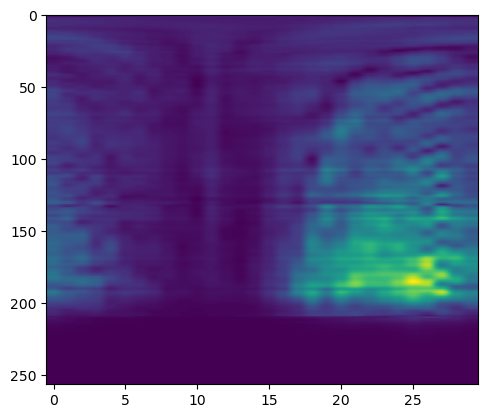

In [80]:
plt.imshow(np.abs(obs_points.reshape(30,257)).T, aspect=0.1)
plt.show()

(7710,)


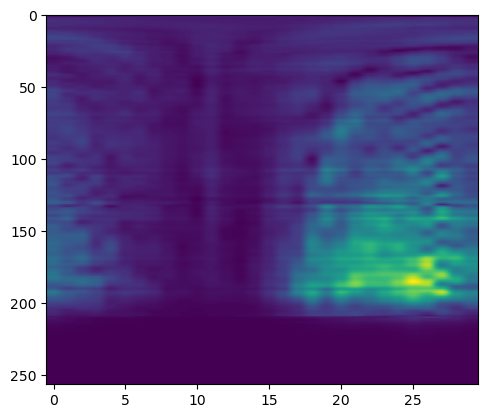

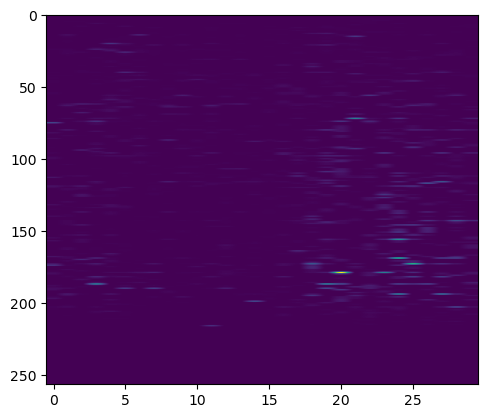

In [81]:
print(est_points_obs.shape)

plt.imshow(np.abs(est_points_obs.reshape(30,257)).T, aspect=0.1)
plt.show()

plt.imshow(np.abs((est_points_obs - obs_points).reshape(30,257)).T, aspect=0.1)
plt.show()

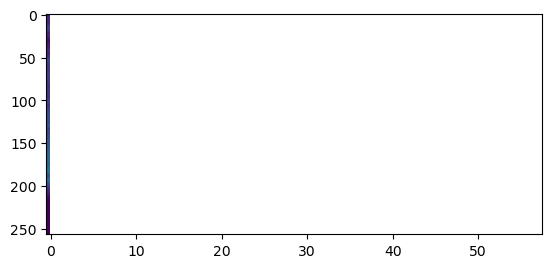

In [82]:
est_points_test = di(test_points[:,0], test_points[:,1], test_points[:,3]) 
plt.figure()
plt.imshow(np.abs(est_points_test.reshape(n_az_test,n_rfft_test)).T, aspect=0.1)
plt.show()

In [56]:
print(est_points_test)

[0.39685263+0.j         0.60880783-0.31604193j 1.55364154+0.12746547j ...
        nan+0.j                nan+0.j                nan+0.j        ]
